In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from datetime import datetime
from dataclasses import dataclass
from scipy.stats import zscore
from tqdm import tqdm

# PyTorch 라이브러리
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
import pickle


In [2]:
BASE_DIR = Path.cwd().resolve().parent.parent

In [3]:
DATA_DIR = BASE_DIR / "data"
MODEL_DIR = BASE_DIR / "model"
RESULTS_DIR = BASE_DIR / "results" / "DL"
NOTEBOOK_DIR = BASE_DIR / "notebook" / "DL"

MODEL_SAVE_DIR = MODEL_DIR
SCALER_SAVE_DIR = MODEL_DIR

RESULTS_SAVE_DIR = RESULTS_DIR
PLOTS_SAVE_DIR = RESULTS_DIR / "plots"
METRICS_SAVE_DIR = RESULTS_DIR / "metrics"

In [4]:
LSTM_CONFIG = {
    "hidden_size": 64,          # LSTM 은닉층 유닛 수
    "num_layers": 2,            # 쌓인 LSTM 레이어 수
    "dropout": 0.2,             # 정규화를 위한 드롭아웃 비율
    "output_size": 1,           # 출력 차원 (단일 타겟)
    "bidirectional": False,     # 양방향 LSTM 사용 여부
}

WINDOW_SIZE = 24                # 슬라이딩 윈도우

TRAINING_CONFIG = {
    "batch_size": 32,           # 학습 배치 크기
    "learning_rate": 1e-3,     # 옵티마이저 학습률
    "num_epochs": 20,          # 최대 학습 에포크 수
    "patience": 10,             # 조기 종료 patience
    "optimizer": "adam",        # 옵티마이저 타입: 'adam', 'rmsprop', 'sgd'
    "loss_function": "mse",     # 손실 함수: 'mse' 또는 'mae'
}

SPLIT_RATIOS = {
    "train": 0.7,               # 학습 세트 비율
    "val": 0.15,                # 검증 세트 비율
    "test": 0.15,               # 테스트 세트 비율
}

FLOW_TARGET = "Q_in"
modelA_TARGET = ["TOC_VU","SS_VU"]
modelB_TARGET = ["TN_VU","TP_VU"]
modelC_TARGET = ["FLUX_VU","PH_VU"]

VISUALIZATION_CONFIG = {
    "dpi": 300,                 # 플롯 해상도
    "figsize": (10, 6),         # 그림 크기 (너비, 높이)
    "font_family": "Malgun Gothic",  # 한글 폰트 지원
    "grid": True,               # 플롯에 그리드 표시
}

RANDOM_SEED = 42

TIME_COL = "SYS_TIME"

MODE = "flow"

HORIZON = 1
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [5]:
class StandardScaler:
    def __init__(self):
        self.mean_ = None
        self.std_ = None

    def fit(self, x):
        self.mean_ = x.mean(axis = 0, keepdims = True)
        self.std_ = x.std(axis = 0, keepdims = True) + 1e-8
        return self
    
    def transform(self, x):
        return (x - self.mean_) / self.std_
    
    def inverse_transform(self, x):
        return x * self.std_ + self.mean_


In [6]:
class TimeSeriesWindowDataset(Dataset):
    def __init__(self, X, y, window_size, horizon):
        self.X = np.asarray(X, dtype=np.float32)
        self.y = np.asarray(y, dtype=np.float32)
        self.window_size = window_size
        self.horizon = horizon

        if self.y.ndim == 1:
            self.y = self.y[:, None]

        self.max_start = len(self.X) - self.window_size - self.horizon + 1
        if self.max_start <= 0:
            raise ValueError("데이터 길이가 window_size + horizon 보다 짧습니다.")
        
    def __len__(self):
        return self.max_start
    
    def __getitem__(self, idx):
        x_seq = self.X[idx : idx + self.window_size]
        y_t = self.y[idx + self.window_size + self.horizon - 1]
        y_t = np.asarray(y_t, dtype=np.float32).reshape(-1)
        return torch.from_numpy(x_seq), torch.from_numpy(y_t)

In [7]:
class LSTMRegressor(nn.Module):
    def __init__(self, n_features, hidden_size = 64, num_layers = 2, dropout = 0.2, out_size = 1):
        super(LSTMRegressor, self).__init__()
        self.lstm = nn.LSTM(
            input_size = n_features,
            hidden_size = hidden_size,
            num_layers = num_layers,
            batch_first = True,
            dropout = dropout if num_layers > 1 else 0.0,
        )
        self.head = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, out_size)
        )

    def forward(self, x):
        out, _ = self.lstm(x)
        last = out[:, -1, :]
        yhat = self.head(last)
        return yhat


In [8]:
def train_model(
    model, 
    train_loader, 
    val_loader, 
    criterion, 
    optimizer, 
    scheduler = None, 
    num_epochs = TRAINING_CONFIG["num_epochs"], 
    patience = TRAINING_CONFIG["patience"],
    device = "cpu",
    save_path = None
):
    train_loss_history = []
    train_mae_history = []
    train_rmse_history = []
    train_mape_history = []
    val_loss_history = []
    val_mae_history = []
    val_rmse_history = []
    val_mape_history = []
    
    best_val_rmse = float("inf")
    best_model_state = None
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0
        epoch_mae = 0.0
        epoch_mse = 0.0
        epoch_mape = 0.0
        train_total = 0

        train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
        for X, y in train_pbar:
            X, y = X.to(device).float(), y.to(device).float()

            optimizer.zero_grad()
            preds = model(X)

            preds = preds.squeeze(-1)
            y = y.squeeze(-1)

            loss = criterion(preds, y)
            loss.backward()
            optimizer.step()

            batch_size = y.size(0)
            train_total += batch_size
            epoch_loss += loss.item() * batch_size

            with torch.no_grad():
                err = preds - y
                abs_err = err.abs()
                epoch_mae += abs_err.sum().item()
                epoch_mse += (err ** 2).sum().item()

                denom = y.abs().clamp_min(1e-6)
                epoch_mape += (abs_err / denom).sum().item()

            train_pbar.set_postfix({
                "loss": f"{loss.item():.4f}",
                "mae": f"{abs_err.mean().item():.4f}",
                "rmse": f"{err.pow(2).mean().sqrt().item():.4f}",
            })

        avg_loss = epoch_loss / train_total
        mae = epoch_mae /train_total
        rmse = (epoch_mse / train_total) ** 0.5
        mape = 100.0 * (epoch_mape / train_total)

        train_loss_history.append(avg_loss)
        train_mae_history.append(mae)
        train_rmse_history.append(rmse)
        train_mape_history.append(mape)

        model.eval()
        val_loss = 0.0
        val_mae = 0.0
        val_mse = 0.0
        val_mape = 0.0
        val_total = 0

        with torch.no_grad():
            val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]")
            for X, y in val_pbar:
                X, y = X.to(device).float(), y.to(device).float()
                outs = model(X)

                outs = outs.squeeze(-1)
                y = y.squeeze(-1)
                
                loss = criterion(outs, y)

                batch_size = y.size(0)
                val_total += batch_size
                val_loss += loss.item() * batch_size

                err = outs - y
                abs_err = err.abs()
                val_mae += abs_err.sum().item()
                val_mse += (err ** 2).sum().item()

                denom = y.abs().clamp_min(1e-6)
                val_mape += (abs_err / denom).sum().item()

                val_pbar.set_postfix({
                    "loss": f"{loss.item():.4f}",
                    "mae": f"{abs_err.mean().item():.4f}",
                    "rmse": f"{err.pow(2).mean().sqrt().item():.4f}",
                })

        v_loss = val_loss / val_total
        v_mae = val_mae / val_total
        v_rmse = (val_mse / val_total) ** 0.5
        v_mape = 100.0 * (val_mape / val_total)

        val_loss_history.append(v_loss)
        val_mae_history.append(v_mae)
        val_rmse_history.append(v_rmse)
        val_mape_history.append(v_mape)

        # 에포크 종료 후 메트릭 출력
        print(f"\nEpoch {epoch+1}/{num_epochs} Summary:")
        print(f"  Train - Loss: {avg_loss:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}, MAPE: {mape:.2f}%")
        print(f"  Val   - Loss: {v_loss:.4f}, MAE: {v_mae:.4f}, RMSE: {v_rmse:.4f}, MAPE: {v_mape:.2f}%")

        if scheduler is not None:
            if hasattr(scheduler, "step") and scheduler.__class__.__name__ == "ReduceLROnPlateau":
                scheduler.step(v_rmse)
            else:
                scheduler.step()

        # Early Stopping 및 Best Model 저장
        if v_rmse < best_val_rmse:
            best_val_rmse = v_rmse
            best_model_state = model.state_dict().copy()
            patience_counter = 0
            print(f"  ✓ New best model! Val RMSE: {best_val_rmse:.4f}")
            
            # 최적 모델 저장
            if save_path is not None:
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': best_model_state,
                    'optimizer_state_dict': optimizer.state_dict(),
                    'val_rmse': best_val_rmse,
                    'train_history': {
                        'train_loss': train_loss_history,
                        'train_mae': train_mae_history,
                        'train_rmse': train_rmse_history,
                        'train_mape': train_mape_history,
                        'val_loss': val_loss_history,
                        'val_mae': val_mae_history,
                        'val_rmse': val_rmse_history,
                        'val_mape': val_mape_history,
                    }
                }, save_path)
                print(f"  ✓ Model saved to {save_path}")
        else:
            patience_counter += 1
            print(f"  No improvement. Patience: {patience_counter}/{patience}")
            
            if patience_counter >= patience:
                print(f"\n⚠ Early stopping triggered after {epoch+1} epochs")
                break

    # 최적 모델 로드
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print(f"\n✓ Loaded best model with Val RMSE: {best_val_rmse:.4f}")

    return {
        "train_loss": train_loss_history,
        "train_mae": train_mae_history,
        "train_rmse": train_rmse_history,
        "train_mape": train_mape_history,
        "val_loss": val_loss_history,
        "val_mae": val_mae_history,
        "val_rmse": val_rmse_history,
        "val_mape": val_mape_history,
        "best_val_rmse": best_val_rmse,
    }


In [9]:
def evaluate_model(model, test_loader, criterion = None, device = "cpu", return_arrays = True):
    model.eval()

    if criterion is None:
        criterion = nn.MSELoss()

    preds_all = []
    y_all = []

    total_loss_sum = 0.0
    mae_sum = 0.0
    mse_sum = 0.0
    mape_sum = 0.0
    n_samples = 0

    with torch.no_grad():
        pbar = tqdm(test_loader, desc = "[Test]")
        for X, y in pbar:
            X = X.to(device).float()
            y = y.to(device).float()

            preds = model(X)

            preds = preds.squeeze(-1)
            y = y.squeeze(-1)

            loss = criterion(preds, y)

            batch_size = y.size(0)
            n_samples += batch_size
            total_loss_sum += loss.item() * batch_size

            err = preds - y
            abs_err = err.abs()
            
            mae_sum += abs_err.sum().item()
            mse_sum += (err ** 2).sum().item()

            denom = y.abs().clamp_min(1e-6)
            mape_sum += (abs_err / denom).sum().item()

            pbar.set_postfix({
                "loss": f"{loss.item():.4f}",
                "mae": f"{abs_err.mean().item():.4f}",
                "rmse": f"{err.pow(2).mean().sqrt().item():.4f}",
            })

            if return_arrays:
                preds_all.append(preds.detach().cpu())
                y_all.append(y.detach().cpu())

    avg_loss = total_loss_sum / n_samples
    mae = mae_sum / n_samples
    rmse = (mse_sum / n_samples) ** 0.5
    mape = 100.0 * (mape_sum / n_samples)

    r2 = None
    if return_arrays and len(y_all) > 0:
        y_cat = torch.cat(y_all).numpy()
        p_cat = torch.cat(preds_all).numpy()
        ss_res = np.sum((y_cat - p_cat) ** 2)
        ss_tot = np.sum((y_cat - np.mean(y_cat)) ** 2)
        r2 = 1.0 - (ss_res / ss_tot) if ss_tot > 0 else None

    print("\n=== 테스트 세트 평가(회귀) ===")
    print(f"Loss: {avg_loss:.4f}")
    print(f"MAE : {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAPE: {mape:.2f}%")
    if r2 is not None:
        print(f"R²  : {r2:.4f}")

    if return_arrays:
        predictions = torch.cat(preds_all).numpy()
        actuals = torch.cat(y_all).numpy()
        return predictions, actuals, {"loss": avg_loss, "mae": mae, "rmse": rmse, "mape": mape, "r2": r2}
    else:
        return {"loss": avg_loss, "mae": mae, "rmse": rmse, "mape": mape, "r2": r2}


In [10]:
def plot_learning_curve(
    train_loss, 
    train_mae, 
    train_rmse, 
    train_mape,
    val_loss=None, 
    val_mae=None, 
    val_rmse=None, 
    val_mape=None,
    title="Training Progress (Regression)"
):
    fig, axes = plt.subplots(2, 2, figsize=(15, 8))
    ax_loss, ax_mae, ax_rmse, ax_mape = axes[0,0], axes[0,1], axes[1,0], axes[1,1]

    # Loss
    ax_loss.plot(train_loss, linewidth=2, label="Train Loss")
    if val_loss is not None and len(val_loss) > 0:
        ax_loss.plot(val_loss, linewidth=2, label="Val Loss")
    ax_loss.set_title("Loss")
    ax_loss.set_xlabel("Epoch"); ax_loss.set_ylabel("Loss")
    ax_loss.legend(); ax_loss.grid(True, alpha=0.3)

    # MAE
    ax_mae.plot(train_mae, linewidth=2, label="Train MAE")
    if val_mae is not None and len(val_mae) > 0:
        ax_mae.plot(val_mae, linewidth=2, label="Val MAE")
    ax_mae.set_title("MAE")
    ax_mae.set_xlabel("Epoch"); ax_mae.set_ylabel("MAE")
    ax_mae.legend(); ax_mae.grid(True, alpha=0.3)

    # RMSE
    ax_rmse.plot(train_rmse, linewidth=2, label="Train RMSE")
    if val_rmse is not None and len(val_rmse) > 0:
        ax_rmse.plot(val_rmse, linewidth=2, label="Val RMSE")
    ax_rmse.set_title("RMSE")
    ax_rmse.set_xlabel("Epoch"); ax_rmse.set_ylabel("RMSE")
    ax_rmse.legend(); ax_rmse.grid(True, alpha=0.3)

    # MAPE
    ax_mape.plot(train_mape, linewidth=2, label="Train MAPE")
    if val_mape is not None and len(val_mape) > 0:
        ax_mape.plot(val_mape, linewidth=2, label="Val MAPE")
    ax_mape.set_title("MAPE (%)")
    ax_mape.set_xlabel("Epoch"); ax_mape.set_ylabel("MAPE (%)")
    ax_mape.legend(); ax_mape.grid(True, alpha=0.3)

    fig.suptitle(title, fontsize=14, fontweight="bold")
    plt.tight_layout()
    plt.show()

In [11]:
def load_data(DATA_DIR):
    dfs = {}

    dfs['flow'] = pd.read_csv(DATA_DIR / "actual/FLOW_Actual.csv")
    dfs['flow']['Q_in'] = dfs['flow']["flow_TankA"] + dfs['flow']['flow_TankB']
    dfs['flow'] = dfs['flow'].drop(columns=["data_save_dt"])
    dfs['tms'] = pd.read_csv(DATA_DIR / "actual/TMS_Actual.csv")
    for station_id in ["368", "541", "569"]:
        aws_path = DATA_DIR / f"actual/AWS_{station_id}.csv"
        df = pd.read_csv(aws_path)
        if "datetime" in df.columns:
            time_col = df["datetime"]
            df = df.drop(columns=["datetime","YYMMDDHHMI","STN"])
            df = df.add_suffix(f"_{station_id}")
            df["SYS_TIME"] = time_col
        else:
            df = df.drop(columns=["YYMMDDHHMI", "STN"])
            df = df.add_suffix(f"_{station_id}")
        dfs[f"aws{station_id}"] = df

    return dfs

In [12]:
def set_datetime_index(df, time_col):
    out = df.copy()
    
    # 시간 컬럼이 존재하는지 확인
    if time_col not in out.columns:
        raise ValueError(f"시간 컬럼 '{time_col}'이 데이터프레임에 없습니다. 사용 가능한 컬럼: {out.columns.tolist()}")
    
    out[time_col] = pd.to_datetime(out[time_col], errors="coerce")
    out = out.dropna(subset=[time_col])
    out = out.set_index(time_col).sort_index()
    return out

In [13]:
def align_data(dfs):
    aligned_dfs = {}
    for name, df in dfs.items():
        time_col = TIME_COL
        df_aligned = set_datetime_index(df, time_col)

        df_aligned = df_aligned.resample("1min").ffill()

        aligned_dfs[name] = df_aligned
            
    return aligned_dfs


In [14]:
def merge_data(dfs):

    valid = {}
    merged_dfs = {}

    for name, df in dfs.items():
        df2 = df.sort_index()
        if df2.index.has_duplicates:
            df2 = df2[~df2.index.duplicated(keep="last")]
        valid[name] = df2

    for name, df in valid.items():
        if name == "flow":
            merged_dfs[name] = pd.concat([
                df,
                valid["aws368"],
                valid["aws541"],
                valid["aws569"],
            ], axis = 1, join = "inner")

        if name == "tms":
            merged_dfs[name] = pd.concat([
                df,
                valid["aws368"],
                valid["aws541"],
                valid["aws569"]
            ], axis = 1, join = "inner")

    return merged_dfs

In [15]:
@dataclass
class ImputationConfig:
    short_term_hours: int = 3
    medium_term_hours: int = 12
    long_term_hours: int = 48
    ewma_span: int = 6

@dataclass
class OutlierConfig:
    method: str = "iqr"
    iqr_threshold: float = 1.5
    zscore_threshold: float = 3.0
    require_both: bool = False

In [16]:
def impute_missing(df, freq = "1h", config = ImputationConfig()):
    df_out = df.copy()

    freq_td = pd.Timedelta(freq)
    freq_hours = freq_td.total_seconds() / 3600

    mask_dict = {}

    for col in df.columns:
        if not pd.api.types.is_numeric_dtype(df[col]):
            continue

        series = df[col].copy()
        original_missing = series.isna()

        mask_dict[f"{col}_is_missing"] = original_missing.astype(int)

        limit_short = max(1, int(config.short_term_hours / freq_hours))
        series_ffill = series.ffill(limit = limit_short)
        ffill_mask = original_missing & ~series_ffill.isna()
        mask_dict[f"{col}_imputed_ffill"] = ffill_mask.astype(int)

        still_missing = series_ffill.isna()
        if still_missing.sum() > 0:
            ewma_span = max(1, int(config.ewma_span / freq_hours))
            series_ewma = series_ffill.ewm(span=ewma_span, adjust=False).mean()
            
            limit_medium = max(1, int(config.medium_term_hours / freq_hours))
            missing_groups = (still_missing != still_missing.shift()).cumsum()
            missing_lengths = still_missing.groupby(missing_groups).transform("sum")
            
            medium_mask = still_missing & (missing_lengths > limit_short) & (missing_lengths <= limit_medium)
            series_ffill[medium_mask] = series_ewma[medium_mask]
            mask_dict[f"{col}_imputed_ewma"] = medium_mask.astype(int)
        else:
            mask_dict[f"{col}_imputed_ewma"] = pd.Series(0, index=df.index, dtype=int)

        still_missing_long = series_ffill.isna()
        if still_missing_long.sum() > 0:
            # 장기 결측용 더 긴 span (기본 span의 4배)
            long_ewma_span = max(1, int(config.ewma_span * 4 / freq_hours))
            series_long_ewma = series_ffill.ewm(span=long_ewma_span, adjust=False).mean()
            
            long_mask = still_missing_long
            series_ffill[long_mask] = series_long_ewma[long_mask]
            mask_dict[f"{col}_imputed_long_ewma"] = long_mask.astype(int)
        else:
            mask_dict[f"{col}_imputed_long_ewma"] = pd.Series(0, index=df.index, dtype=int)

        df_out[col] = series_ffill

    df_mask = pd.DataFrame(mask_dict, index=df.index)
    
    return df_out, df_mask

In [17]:
def imputate_data(dfs):
    config_impute = ImputationConfig()
    imputed_dfs = {}
    mask_imputed_dfs = {}

    for name, df in dfs.items():
        print(f"\n{'='*60}")
        print(f"{name} 결측치 처리")
        print(f"{'='*60}")
        print(f"결측치 처리 전:")
        print(f"  총 결측치: {df.isna().sum().sum()}")
        print(f"  결측치 있는 컬럼: {(df.isna().sum() > 0).sum()}개")

        df_imputed, mask_imputed = impute_missing(df, freq="1min", config = config_impute)

        imputed_dfs[name] = df_imputed
        mask_imputed_dfs[name] = mask_imputed

        print(f"\n결측치 처리 후:")
        print(f"  총 결측치: {df_imputed.isna().sum().sum()}")
        print(f"  데이터 shape: {df_imputed.shape}")
        print(f"  마스크 shape: {mask_imputed.shape}")

    return imputed_dfs, mask_imputed_dfs

In [18]:
def outliers_domain(series, col_name):
    outliers = pd.Series([False] * len(series), index = series.index)

    if not pd.api.types.is_numeric_dtype(series):
        return outliers
    
    domain_rules = {
        "TOC_VU": (0, 250),
        "PH_VU": (0, 14),
        "SS_VU": (0, 100),
        "TN_VU": (0, 100),
        "TP_VU": (0, 20),
        "level_TankA": (0, 10),
        "level_TankB": (0, 10),
        "TA": (-30, 45),
        "HM": (0, 100),
        "TD": (-40, 35),
    }

    if col_name in domain_rules:
        lower, upper = domain_rules[col_name]
        outliers = (series < lower) | (series > upper)
    elif "RN_" in col_name:
        outliers = (series < 0) | (series > 300)
    elif "flow" in col_name.lower() or "flux" in col_name.lower():
        valid_values = series.dropna()
        if len(valid_values) > 0:
            outliers = (series < 0) | (series > valid_values.quantile(0.99) * 3)
    else:
        valid_values = series.dropna()
        if len(valid_values) > 0:
            outliers = (series < 0) | (series > valid_values.quantile(0.999) * 2)
    
    return outliers

In [19]:
def outliers_statistical(series, 
                        method = 'iqr', 
                        iqr_threshold = 1.5, 
                        zscore_threshold = 3.0):
    outliers = pd.Series([False] * len(series), index=series.index)

    if not pd.api.types.is_numeric_dtype(series):
        return outliers
    
    if method == 'iqr':
        Q1 = series.quantile(0.25)
        Q3 = series.quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - iqr_threshold * IQR
        upper = Q3 + iqr_threshold * IQR
        outliers = (series < lower) | (series > upper)
    
    elif method == 'zscore':
        # NaN 제거 후 Z-score 계산
        valid_mask = ~series.isna()
        if valid_mask.sum() > 0:
            z_scores = np.abs(zscore(series[valid_mask]))
            outliers[valid_mask] = z_scores > zscore_threshold
    
    return outliers

In [20]:
def process_outliers(df, config = OutlierConfig(), ewma_span = 12):
    df_out = df.copy()
    mask_dict = {}

    for col in df.columns:
        if not pd.api.types.is_numeric_dtype(df[col]):
            continue

        series = df[col].copy()

        domain_outliers = outliers_domain(series, col)

        stats_outliers = outliers_statistical(series, method = config.method, iqr_threshold=config.iqr_threshold, zscore_threshold=config.zscore_threshold)

        if config.require_both:
            final_outliers = domain_outliers & stats_outliers
        else:
            final_outliers = domain_outliers | stats_outliers

        mask_dict[f"{col}_outlier_domain"] = domain_outliers.astype(int)
        mask_dict[f"{col}_outlier_stats"] = stats_outliers.astype(int)
        mask_dict[f"{col}_outlier_final"] = final_outliers.astype(int)

        # EWMA로 이상치 대체
        if final_outliers.sum() > 0:
            series_ewma = series.ewm(span=ewma_span, adjust=False).mean()
            series[final_outliers] = series_ewma[final_outliers]
            mask_dict[f"{col}_outlier_replaced_ewma"] = final_outliers.astype(int)
        else:
            mask_dict[f"{col}_outlier_replaced_ewma"] = pd.Series(0, index=df.index, dtype=int)

        df_out[col] = series

    df_mask = pd.DataFrame(mask_dict, index=df.index)

    return df_out, df_mask

In [21]:
def handle_outliers(dfs):
    config_outlier = OutlierConfig()
    processed_dfs = {}
    mask_processed_dfs = {}

    for name, df in dfs.items():
        print(f"\n{'='*60}")
        print(f"{name} 이상치 처리")
        print(f"{'='*60}")

        df_outlier, mask_outlier = process_outliers(df, config = config_outlier, ewma_span = 12)

        processed_dfs[name] = df_outlier
        mask_processed_dfs[name] = mask_outlier

    return processed_dfs, mask_processed_dfs

In [22]:
def resample_data(df, freq = "1h", agg = "mean"):
    if not isinstance(df.index, pd.DatetimeIndex) :
        raise ValueError("리샘플링을 위해서는 DatetimeIndex가 필요합니다")
    
    numeric_cols = df.select_dtypes(include = [np.number]).columns
    df_numeric = df[numeric_cols]

    return df_numeric.resample(freq).agg(agg)

In [23]:
def select_features(df, mode):
    df_out = df.copy()

    if mode == "flow":
        pass
    elif mode == "modelA":
        pass
    elif mode == "modelB":
        pass
    else:
        pass

    return df_out

In [24]:
def preprocess_data(dfs):
    # 시간 축 정렬
    aligned_dfs = align_data(dfs)

    # 데이터 병합(flow, tms)
    merged_dfs = merge_data(aligned_dfs)

    # 결측치 처리
    imputed_dfs, mask_imputed_dfs = imputate_data(merged_dfs)

    # 이상치 처리
    processed_dfs, mask_process_dfs = handle_outliers(imputed_dfs)

    # 리샘플링
    resample_dfs = {}
    for name, df in processed_dfs.items():
        resample_dfs[name] = resample_data(df)

    # 특성 엔지니어링 및 선택
    mode = MODE
    df = select_features(resample_dfs[mode], mode)

    if mode == "flow":
        target_col = FLOW_TARGET
    elif mode == "modelA":
        target_col = modelA_TARGET
    elif mode == "modelB":
        target_col = modelB_TARGET
    else:
        target_col = modelC_TARGET

    X = df.drop(columns=target_col).values
    y = df[[target_col]].to_numpy(dtype="float32")

    return X, y

In [25]:
def split_timewise(X, y, ratio = SPLIT_RATIOS):
    T = len(X)
    n_train = int(T * ratio["train"])
    n_val = int(T * ratio["val"])

    X_train, y_train = X[:n_train], y[:n_train]
    X_val, y_val = X[n_train : n_train + n_val], y[n_train : n_train + n_val]
    X_test, y_test = X[n_train + n_val : ], y[n_train + n_val : ]

    return X_train, y_train, X_val, y_val, X_test, y_test

In [26]:
def scale_data(X_train, y_train, X_val, y_val, X_test, y_test):

    x_scaler = StandardScaler().fit(X_train)
    y_scaler = StandardScaler().fit(y_train)

    X_train_scaled = x_scaler.transform(X_train)
    X_val_scaled = x_scaler.transform(X_val)
    X_test_scaled = x_scaler.transform(X_test)

    y_train_scaled = y_scaler.transform(y_train)
    y_val_scaled = y_scaler.transform(y_val)
    y_test_scaled = y_scaler.transform(y_test)

    return X_train_scaled, X_val_scaled, X_test_scaled, y_train_scaled, y_val_scaled, y_test_scaled, x_scaler, y_scaler


In [27]:
def ensure_2d_y(y):
    y = np.asarray(y, dtype = np.float32)
    if y.ndim == 1:
        y = y[:, None]
    return y

In [30]:
def main():

    dfs = load_data(DATA_DIR)
    
    X, y = preprocess_data(dfs)

    X_train, y_train, X_val, y_val, X_test, y_test = split_timewise(X, y)

    X_tr_s, X_va_s, X_te_s, y_tr_s, y_va_s, y_te_s, x_scaler, y_scaler = scale_data(
        X_train, y_train, X_val, y_val, X_test, y_test
    )

    # 스케일러 저장
    SCALER_SAVE_DIR.mkdir(parents=True, exist_ok=True)
    with open(SCALER_SAVE_DIR / "X_scaler.pkl", "wb") as f:
        pickle.dump(x_scaler, f)
    with open(SCALER_SAVE_DIR / "y_scaler.pkl", "wb") as f:
        pickle.dump(y_scaler, f)
    print(f"\n✓ Scalers saved to {SCALER_SAVE_DIR}")

    y_tr_s = ensure_2d_y(y_tr_s)
    y_va_s = ensure_2d_y(y_va_s)
    y_te_s = ensure_2d_y(y_te_s)

    train_ds = TimeSeriesWindowDataset(X_tr_s, y_tr_s, WINDOW_SIZE, HORIZON)
    val_ds = TimeSeriesWindowDataset(X_va_s, y_va_s, WINDOW_SIZE, HORIZON)
    test_ds = TimeSeriesWindowDataset(X_te_s, y_te_s, WINDOW_SIZE, HORIZON)

    train_dl = DataLoader(train_ds,
                          batch_size=TRAINING_CONFIG["batch_size"],
                          shuffle=False,
                          drop_last=False)
    val_dl = DataLoader(val_ds,
                        batch_size=TRAINING_CONFIG["batch_size"],
                        shuffle=False,
                        drop_last=False)
    test_dl = DataLoader(test_ds,
                         batch_size=TRAINING_CONFIG["batch_size"],
                         shuffle=False,
                         drop_last=False)
    
    n_features = X_tr_s.shape[1]
    out_size = y_tr_s.shape[1]
    model = LSTMRegressor(n_features=n_features,
                          hidden_size=LSTM_CONFIG["hidden_size"],
                          num_layers=LSTM_CONFIG["num_layers"],
                          dropout=LSTM_CONFIG["dropout"],
                          out_size=out_size).to(DEVICE)
    
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = TRAINING_CONFIG["learning_rate"])
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

    # 모델 저장 경로 설정
    MODEL_SAVE_DIR.mkdir(parents=True, exist_ok=True)
    model_save_path = MODEL_SAVE_DIR / f"{MODE}_lstm_model.pth"

    hist = train_model(
        model, 
        train_dl, 
        val_dl, 
        criterion, 
        optimizer, 
        scheduler, 
        num_epochs=TRAINING_CONFIG["num_epochs"],
        patience=TRAINING_CONFIG["patience"],
        device=DEVICE,
        save_path=model_save_path
    )
    
    plot_learning_curve(
        train_loss=hist["train_loss"],
        train_mae=hist["train_mae"],
        train_rmse=hist["train_rmse"],
        train_mape=hist["train_mape"],
        val_loss=hist["val_loss"],
        val_mae=hist["val_mae"],
        val_rmse=hist["val_rmse"],
        val_mape=hist["val_mape"],
    )
    
    # 테스트 평가
    predictions, actuals, test_metrics = evaluate_model(model, test_dl, criterion, device=DEVICE)
    
    # 예측 결과 저장
    RESULTS_SAVE_DIR.mkdir(parents=True, exist_ok=True)
    results_df = pd.DataFrame({
        'actual': actuals.flatten(),
        'predicted': predictions.flatten()
    })
    results_df.to_csv(RESULTS_SAVE_DIR / f"{MODE}_predictions.csv", index=False)
    print(f"\n✓ Predictions saved to {RESULTS_SAVE_DIR / f'{MODE}_predictions.csv'}")
    
    return model, hist, test_metrics



flow 결측치 처리
결측치 처리 전:
  총 결측치: 108578
  결측치 있는 컬럼: 21개

결측치 처리 후:
  총 결측치: 818
  데이터 shape: (131687, 26)
  마스크 shape: (131687, 104)

tms 결측치 처리
결측치 처리 전:
  총 결측치: 680324
  결측치 있는 컬럼: 27개

결측치 처리 후:
  총 결측치: 0
  데이터 shape: (573975, 27)
  마스크 shape: (573975, 108)

flow 이상치 처리

tms 이상치 처리

✓ Scalers saved to C:\project_WWTP\python\model


Epoch 1/20 [Val]: 100%|██████████| 10/10 [00:00<00:00, 337.41it/s, loss=nan, mae=nan, rmse=nan]



Epoch 1/20 Summary:
  Train - Loss: nan, MAE: nan, RMSE: nan, MAPE: nan%
  Val   - Loss: nan, MAE: nan, RMSE: nan, MAPE: nan%
  No improvement. Patience: 1/10


Epoch 2/20 [Val]: 100%|██████████| 10/10 [00:00<00:00, 323.22it/s, loss=nan, mae=nan, rmse=nan]



Epoch 2/20 Summary:
  Train - Loss: nan, MAE: nan, RMSE: nan, MAPE: nan%
  Val   - Loss: nan, MAE: nan, RMSE: nan, MAPE: nan%
  No improvement. Patience: 2/10


Epoch 3/20 [Val]: 100%|██████████| 10/10 [00:00<00:00, 329.44it/s, loss=nan, mae=nan, rmse=nan]



Epoch 3/20 Summary:
  Train - Loss: nan, MAE: nan, RMSE: nan, MAPE: nan%
  Val   - Loss: nan, MAE: nan, RMSE: nan, MAPE: nan%
  No improvement. Patience: 3/10


Epoch 4/20 [Val]: 100%|██████████| 10/10 [00:00<00:00, 340.50it/s, loss=nan, mae=nan, rmse=nan]



Epoch 4/20 Summary:
  Train - Loss: nan, MAE: nan, RMSE: nan, MAPE: nan%
  Val   - Loss: nan, MAE: nan, RMSE: nan, MAPE: nan%
  No improvement. Patience: 4/10


Epoch 5/20 [Val]: 100%|██████████| 10/10 [00:00<00:00, 314.13it/s, loss=nan, mae=nan, rmse=nan]



Epoch 5/20 Summary:
  Train - Loss: nan, MAE: nan, RMSE: nan, MAPE: nan%
  Val   - Loss: nan, MAE: nan, RMSE: nan, MAPE: nan%
  No improvement. Patience: 5/10


Epoch 6/20 [Val]: 100%|██████████| 10/10 [00:00<00:00, 336.10it/s, loss=nan, mae=nan, rmse=nan]



Epoch 6/20 Summary:
  Train - Loss: nan, MAE: nan, RMSE: nan, MAPE: nan%
  Val   - Loss: nan, MAE: nan, RMSE: nan, MAPE: nan%
  No improvement. Patience: 6/10


Epoch 7/20 [Val]: 100%|██████████| 10/10 [00:00<00:00, 343.08it/s, loss=nan, mae=nan, rmse=nan]



Epoch 7/20 Summary:
  Train - Loss: nan, MAE: nan, RMSE: nan, MAPE: nan%
  Val   - Loss: nan, MAE: nan, RMSE: nan, MAPE: nan%
  No improvement. Patience: 7/10


Epoch 8/20 [Val]: 100%|██████████| 10/10 [00:00<00:00, 322.77it/s, loss=nan, mae=nan, rmse=nan]



Epoch 8/20 Summary:
  Train - Loss: nan, MAE: nan, RMSE: nan, MAPE: nan%
  Val   - Loss: nan, MAE: nan, RMSE: nan, MAPE: nan%
  No improvement. Patience: 8/10


Epoch 9/20 [Val]: 100%|██████████| 10/10 [00:00<00:00, 346.69it/s, loss=nan, mae=nan, rmse=nan]



Epoch 9/20 Summary:
  Train - Loss: nan, MAE: nan, RMSE: nan, MAPE: nan%
  Val   - Loss: nan, MAE: nan, RMSE: nan, MAPE: nan%
  No improvement. Patience: 9/10


Epoch 10/20 [Val]: 100%|██████████| 10/10 [00:00<00:00, 344.25it/s, loss=nan, mae=nan, rmse=nan]



Epoch 10/20 Summary:
  Train - Loss: nan, MAE: nan, RMSE: nan, MAPE: nan%
  Val   - Loss: nan, MAE: nan, RMSE: nan, MAPE: nan%
  No improvement. Patience: 10/10

⚠ Early stopping triggered after 10 epochs


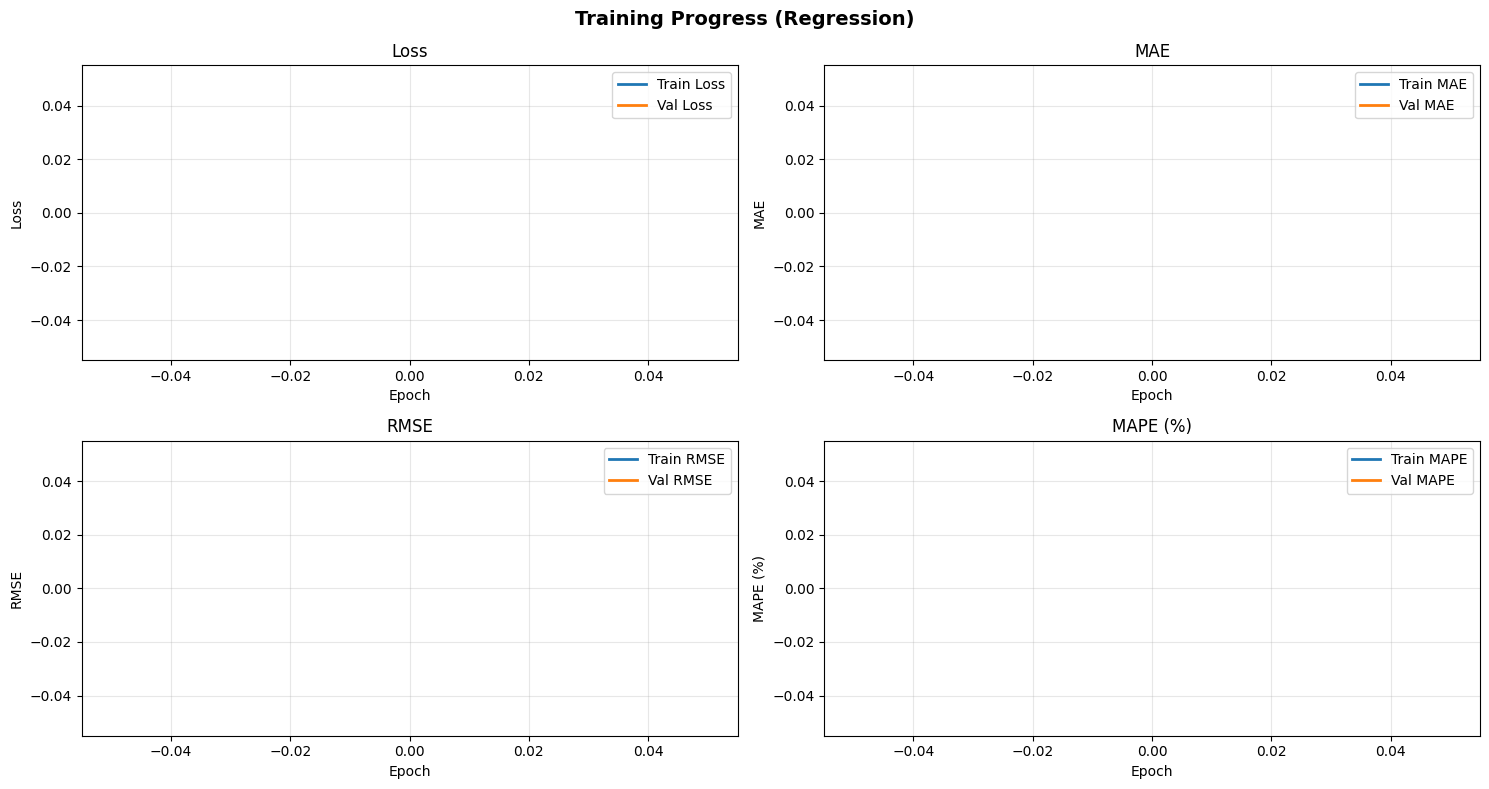

[Test]: 100%|██████████| 10/10 [00:00<00:00, 300.05it/s, loss=nan, mae=nan, rmse=nan]


=== 테스트 세트 평가(회귀) ===
Loss: nan
MAE : nan
RMSE: nan
MAPE: nan%
R²  : nan

✓ Predictions saved to C:\project_WWTP\python\results\DL\flow_predictions.csv


(LSTMRegressor(
   (lstm): LSTM(25, 64, num_layers=2, batch_first=True, dropout=0.2)
   (head): Sequential(
     (0): Linear(in_features=64, out_features=64, bias=True)
     (1): ReLU()
     (2): Linear(in_features=64, out_features=1, bias=True)
   )
 ),
 {'train_loss': [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
  'train_mae': [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
  'train_rmse': [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
  'train_mape': [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
  'val_loss': [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
  'val_mae': [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
  'val_rmse': [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
  'val_mape': [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
  'best_val_rmse': inf},
 {'loss': nan, 'mae': nan, 'rmse': nan, 'mape': nan, 'r2': np.float32(nan)})

In [31]:
main()